In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

file_path = '/content/vgchartz-2024.csv'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"El archivo en la ruta {file_path} no fue encontrado. Por favor, asegúrate de que el archivo esté cargado correctamente.")

data = pd.read_csv(file_path)

print("Vista inicial del dataset:")
print(data.head())

print("\nInformación del dataset antes de la limpieza:")
print(data.info())

Vista inicial del dataset:
                                             img                        title  \
0  /games/boxart/full_6510540AmericaFrontccc.jpg           Grand Theft Auto V   
1  /games/boxart/full_5563178AmericaFrontccc.jpg           Grand Theft Auto V   
2                    /games/boxart/827563ccc.jpg  Grand Theft Auto: Vice City   
3  /games/boxart/full_9218923AmericaFrontccc.jpg           Grand Theft Auto V   
4  /games/boxart/full_4990510AmericaFrontccc.jpg    Call of Duty: Black Ops 3   

  console    genre       publisher       developer  critic_score  total_sales  \
0     PS3   Action  Rockstar Games  Rockstar North           9.4        20.32   
1     PS4   Action  Rockstar Games  Rockstar North           9.7        19.39   
2     PS2   Action  Rockstar Games  Rockstar North           9.6        16.15   
3    X360   Action  Rockstar Games  Rockstar North           NaN        15.86   
4     PS4  Shooter      Activision        Treyarch           8.1        15.09   


### Limpieza de datos
Eliminamos columnas irrelevantes y filas con valores nulos.

In [2]:
columns_to_drop = ["img", "last_update", "release_date"]
data = data.drop(columns=columns_to_drop, errors='ignore')
data = data.dropna()

### Crear la columna de popularidad
Definimos una nueva columna categórica que clasifica los videojuegos según las ventas totales.

In [3]:
def classify_popularity(row):
    if row['total_sales'] > 5:
        return 'Muy Popular'
    elif row['total_sales'] > 1:
        return 'Moderadamente Popular'
    else:
        return 'Menos Popular'

if 'total_sales' not in data.columns:
    raise KeyError("La columna 'total_sales' no existe en el dataset. Verifica los nombres de las columnas disponibles.")

data['Popularity'] = data.apply(classify_popularity, axis=1)

popularity_mapping = {'Muy Popular': 2, 'Moderadamente Popular': 1, 'Menos Popular': 0}
data['Popularity'] = data['Popularity'].map(popularity_mapping)

### Selección de características relevantes
Seleccionamos las columnas que serán utilizadas como variables predictoras y se verifica que existan en el dataset.

In [4]:
features = ["critic_score", "na_sales", "pal_sales", "jp_sales"]
target = "Popularity"

missing_features = [feature for feature in features if feature not in data.columns]
if missing_features:
    raise ValueError(f"Las siguientes características no están en el dataset: {missing_features}. Columnas disponibles: {list(data.columns)}")

### Dividir datos en entrenamiento y prueba

In [5]:
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Entrenar el modelo Random Forest


In [6]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Evaluación del modelo
Envaluamos el modelo utilizando el conjunto de prueba.


Matriz de confusión:
[[140   2   0]
 [  7  80   1]
 [  0   3   9]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       142
           1       0.94      0.91      0.92        88
           2       0.90      0.75      0.82        12

    accuracy                           0.95       242
   macro avg       0.93      0.88      0.90       242
weighted avg       0.95      0.95      0.95       242



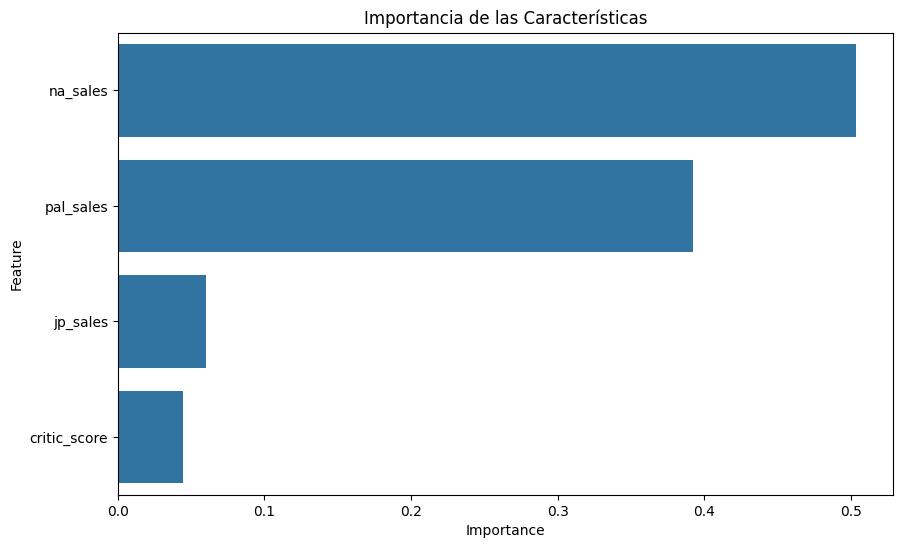

In [7]:
y_pred = rf.predict(X_test)
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Importancia de las Características')
plt.show()

### Visualización de la matriz de confusión
Esta celda genera un gráfico que visualiza los resultados de la matriz de confusión.

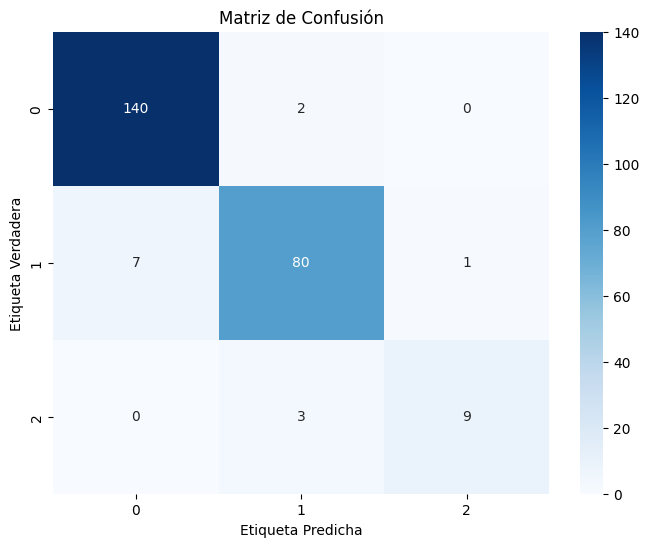

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Conclusiones

### Conclusión

El modelo Random Forest aplicado logró un desempeño general sólido, alcanzando una exactitud del 95% en la clasificación de los videojuegos según su popularidad. Las métricas de precisión y exhaustividad fueron consistentemente altas para las clases de `Menos Populares` y `Moderadamente Populares`, mientras que para la clase `Muy Populares`, aunque aceptable, se observó una menor exhaustividad (recall del 75%), probablemente debido al bajo número de instancias en esta categoría.

El análisis de la importancia de las características mostró que las ventas en América del Norte (`na_sales`) y Europa (`pal_sales`) son los principales factores que contribuyen a la predicción, mientras que las ventas en Japón (`jp_sales`) y las puntuaciones críticas (`critic_score`) tienen un impacto menor pero relevante. Esto indica que las dinámicas de ventas regionales son cruciales para determinar la popularidad de un videojuego.

En resumen, el modelo es adecuado para esta tarea de clasificación y muestra un buen equilibrio en su desempeño, aunque podría beneficiarse de ajustes específicos para mejorar la clasificación en categorías con menos datos representativos.